<h1> Predict Stock Prices</h1>
<h3>Basic Overview:</h3>
1. Import stock tickers by web scraping.<br/>
2. Scrape Yahoo for stock details using the ticker names.<br/>
3. Compile all stock detail into a single dataset with a target stock to predict in mind.<br/>
4. Create features based on your target stock, such as the rate increase in volume. <br/> 
<strong>If you have already scraped/formatted data and have not changed your target stock, you can skip to <a href=#start>section 5.</a>

<h3>Section 1: Scrape for stock tickers.

In [ ]:
import bs4 as bs
import pickle
import requests

def save_tickers():
    
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text)
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[:-1]
        tickers.append(ticker)
        
    with open("tickers.pickle",'wb') as f:
        pickle.dump(tickers,f)
    
    return tickers

save_tickers()

<h3> Section 2: Scrape yahoo for stock details.

In [ ]:
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web

def fetch_data():
    with open("tickers.pickle",'rb') as f:
        tickers = pickle.load(f)
    
    if not os.path.exists('stock_details'):
        os.makedirs('stock_details')
    
    count = 200
    
    start = dt.datetime(2010,1,1)
    end = dt.datetime(2020,6,22)
    count = 0
    for ticker in tickers:
        if count==200:
            break
        count += 1
        print(ticker)
        try:
            df=web.DataReader(ticker,'yahoo',start,end)
            
            df.to_csv('stock_details/{}.csv'.format(ticker))
        except:
            print("Error")
            continue

In [ ]:
fetch_data()

<h3>Section 3: Compile stock close prices into one dataset (besides the target stock)</h3>
<p> Current target stock: AMZN

In [5]:
target_stock = 'AMZN'

In [ ]:
def compile():
    with open("tickers.pickle",'rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        if target_stock in ticker:
            continue
        if not os.path.exists('stock_details/{}.csv'.format(ticker)):
            continue
        
        df = pd.read_csv('stock_details/{}.csv'.format(ticker))
        df.set_index('Date',inplace=True)
        
        df.rename(columns={'Adj Close':ticker},inplace=True)
        df.drop(['Open','High','Low',"Close",'Volume'],axis=1,inplace=True)
        
        if main_df.empty:
            main_df=df
        else:
            main_df = main_df.join(df,how='outer')
        
    print(main_df.head())
    main_df.to_csv('Dataset_temp.csv')
                

In [ ]:
import pickle
import os
compile()

<h1><Section 4:

<h3>Section 4: Visualize with candlestick and create features.</h3>


In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd

df = pd.read_csv(f'stock_details/{target_stock}.csv',index_col=0,parse_dates=True)
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc.reset_index(inplace=True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1,colspan=1, sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1,df_ohlc.values, width=2,colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0)

plt.show()

In [ ]:
main_df = pd.read_csv('Dataset_temp.csv')

df['Moving_av'] = df['Adj Close'].rolling(window=50,min_periods=0).mean()

i = 1
rate_increase_in_vol = [0]
rate_increase_in_adj_close = [0]

while i<len(df):
    rate_increase_in_vol.append(df.iloc[i]['Volume'] - df.iloc[i-1]['Volume'])
    rate_increase_in_adj_close.append(df.iloc[i]['Adj Close'] - df.iloc[i-1]['Adj Close'])
    i+=1

df['Increase_in_vol']=rate_increase_in_vol
df['Increase_in_adj_close']=rate_increase_in_adj_close    

df.to_csv("Dataset_target.csv",index=False)

dfdates = pd.read_csv(f'stock_details/{target_stock}.csv')

Dates=[]
i=0
while i<len(df):
    Dates.append(dfdates.iloc[i]['Date'])
    i+=1

df['Date'] = Dates

newdf = main_df.set_index('Date')

testdf = df.join(newdf)



In [14]:
testdf.to_csv(f"Final_{target_stock}_data.csv")

<h3>Section 5: Regression </h3>
<p><strong><a name="start"/>NOTE:</strong> In most cases, you'll need to start here. You don't need to do Sections 1-4 each time unless you are changing the target stock or want an updated dataset. You'll just need to reload the final df (testdf) from Section 4.

In [15]:
# RELOADING DATA IF SKIPPING SECTIONS 1-4
finaldf = pd.read_csv(f"Final_{target_stock}_data.csv")

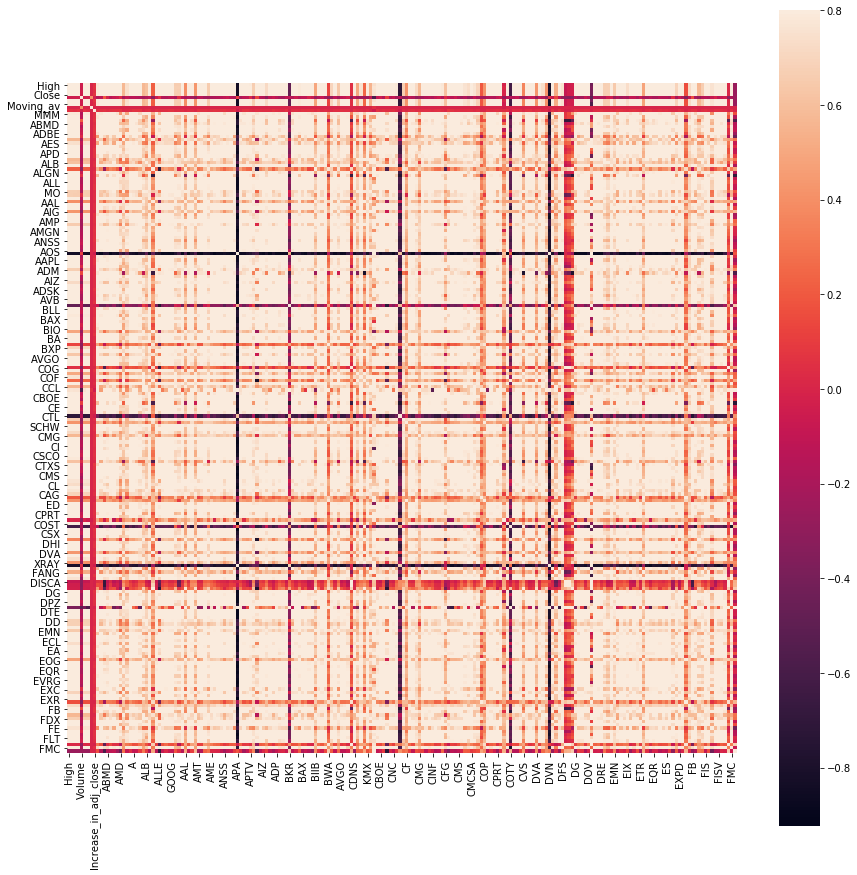

In [18]:
import seaborn as sb
import matplotlib.pyplot as plt
C_mat = finaldf.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat,vmax=.8,square=True)
plt.show()

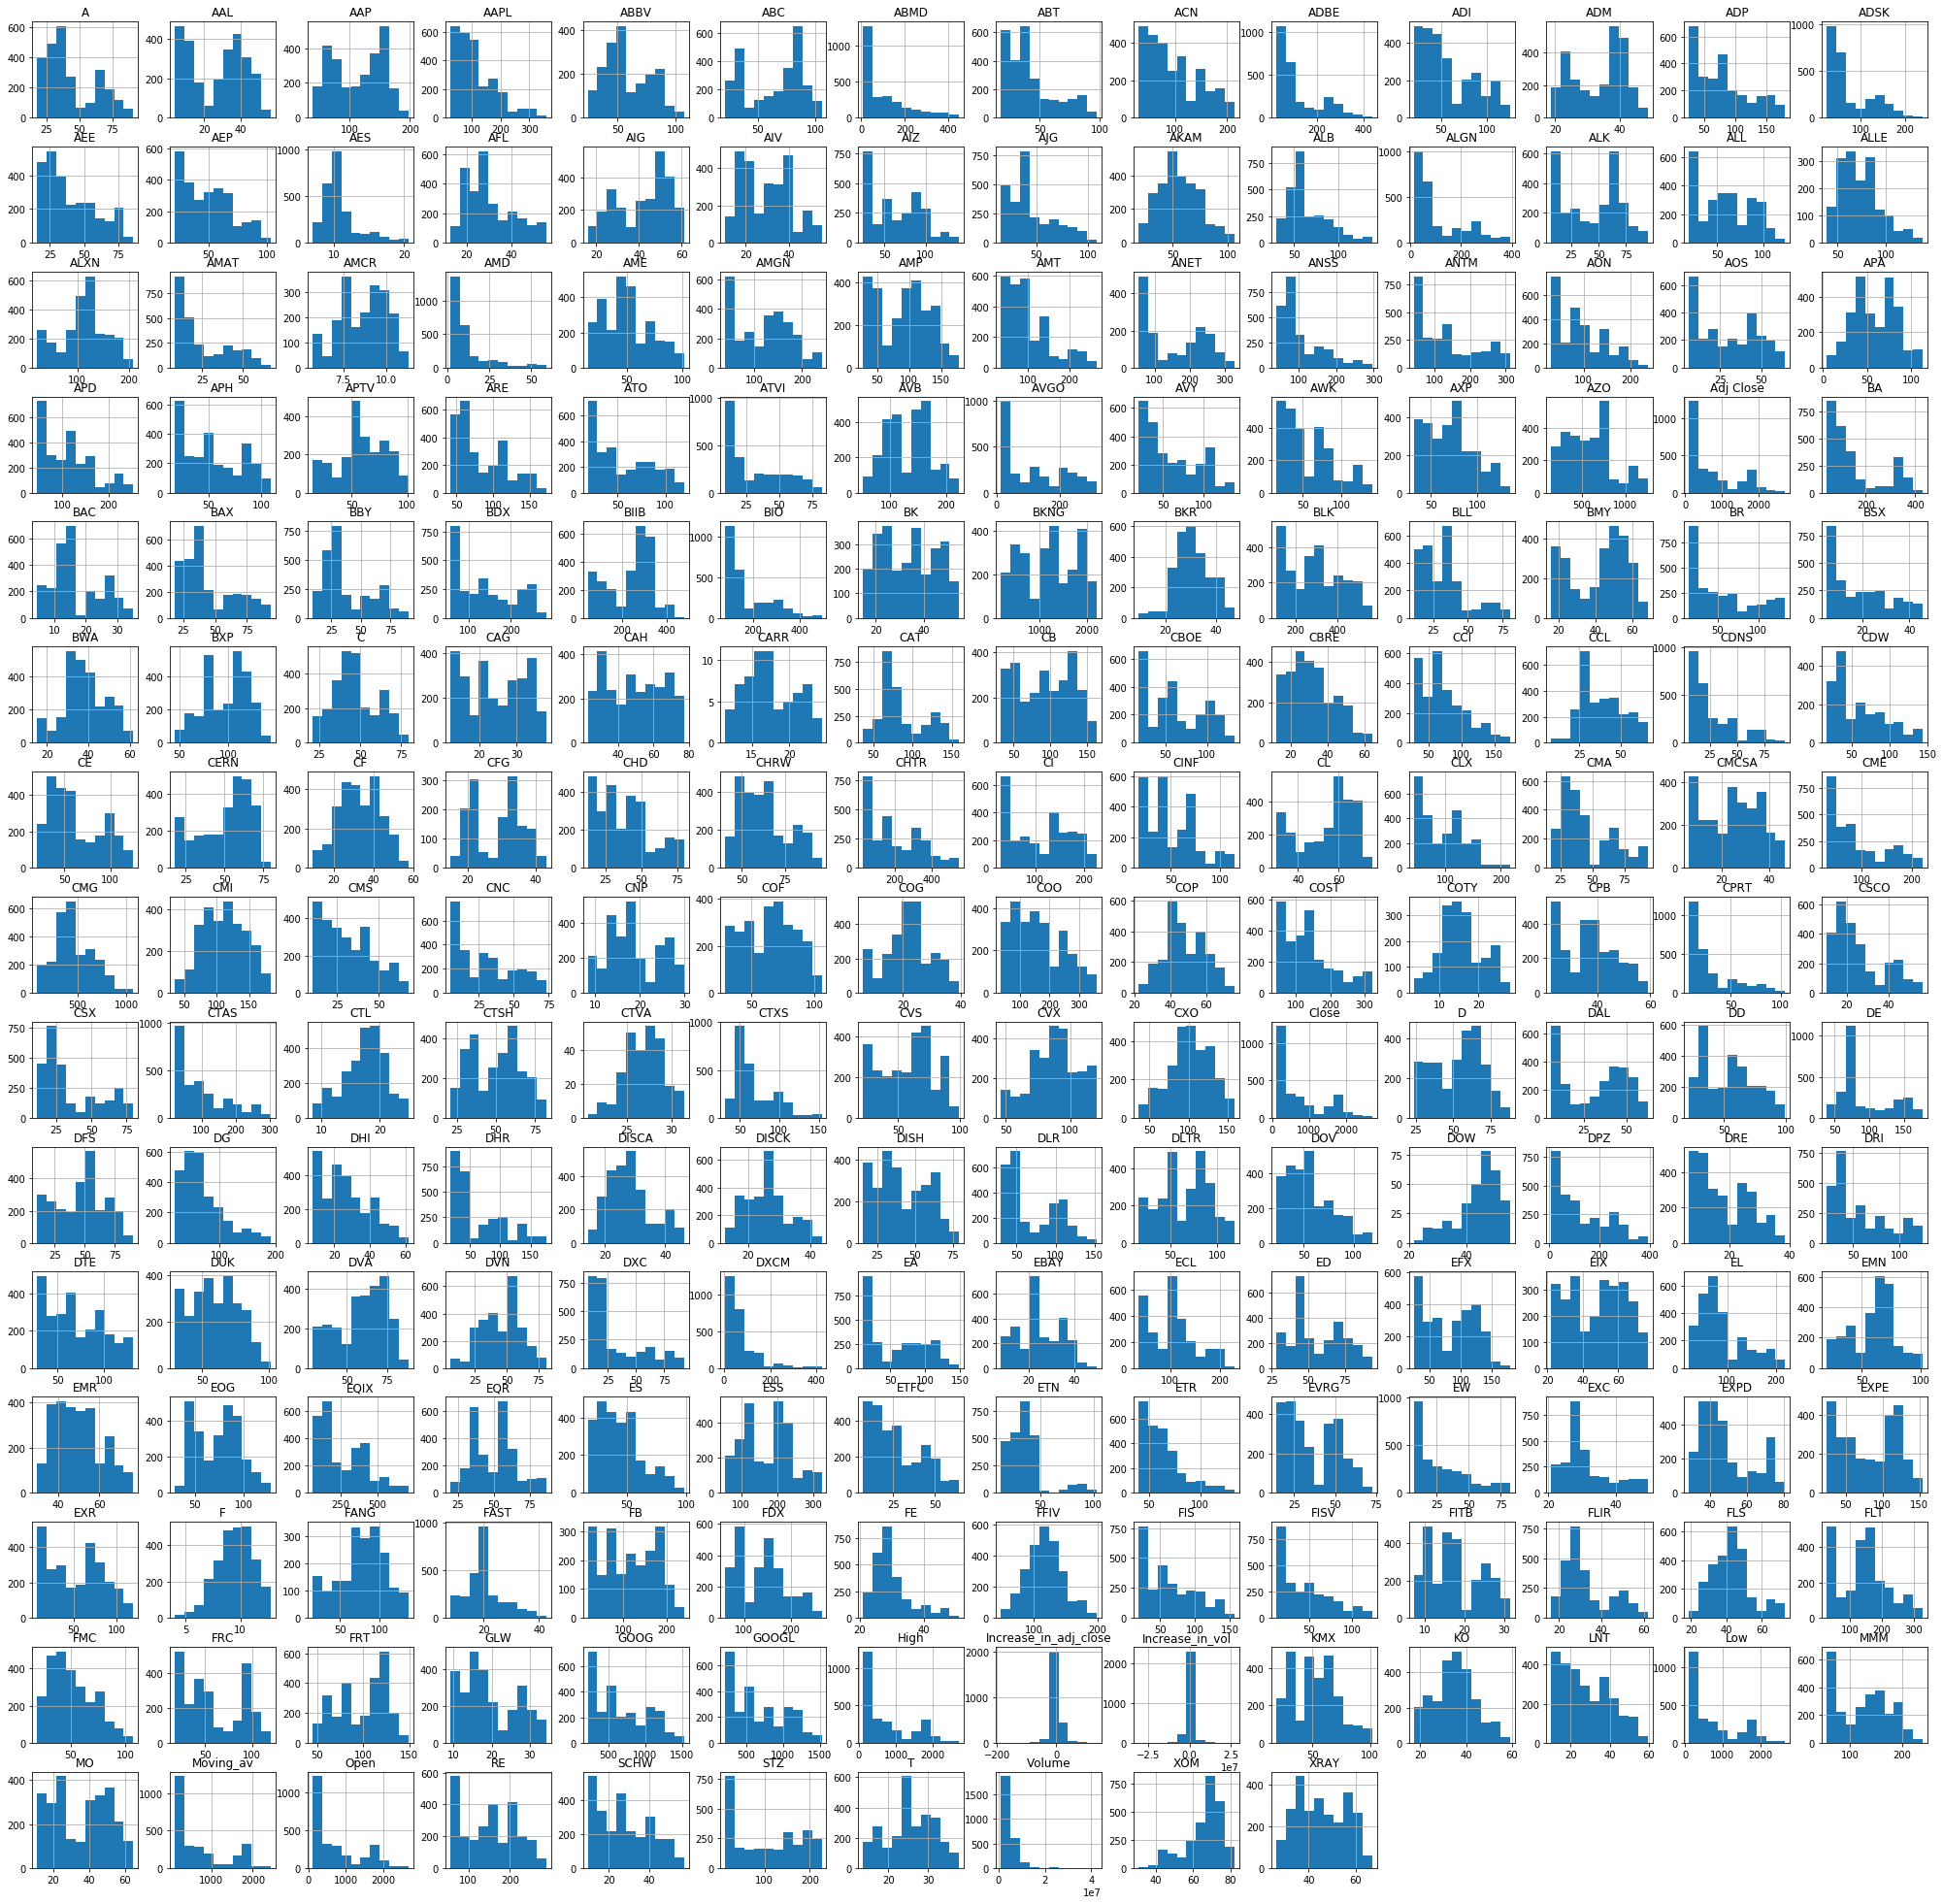

In [19]:
finaldf.hist(figsize=(35,35))
plt.show()

In [20]:
finaldf.fillna(0,inplace=True)

In [21]:
y_df = finaldf[['High','Low','Open','Close','Volume','Adj Close']]

In [22]:
y_df_mod = y_df.drop(['Adj Close','Volume'],axis=1)

In [45]:
col_y = y_df.columns
Drop_cols = col_y
Drop_cols = Drop_cols.tolist()
Drop_cols.append('Date')

In [46]:
Drop_cols

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date']

In [47]:
X_df = finaldf.drop(Drop_cols,axis=1)

In [52]:
X = X_df.values
y = y_df_mod.values

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)